<a href="https://colab.research.google.com/github/srivatsan88/End-to-End-Time-Series/blob/master/Multivariate_Time_Series_using_VAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
from math import sqrt
import numpy as np
import pandas as pd
from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from xgboost import XGBRegressor

# load dataset
stock_price_df = read_csv('./data/VN30.csv', header=0, index_col=0)
values = stock_price_df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
stock_price_df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2012-06-18,510.81,509.62,514.55,508.64,22.57,0.57
2012-06-19,506.67,508.37,510.60,505.02,12.69,-0.81
2012-06-20,508.23,507.23,510.37,504.02,10.66,0.31
2012-06-21,504.71,504.85,507.84,504.52,13.24,-0.69
2012-06-22,500.34,503.97,504.21,499.40,17.35,-0.87


In [23]:
column_names = stock_price_df.columns

In [24]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('{}(t-{})'.format(column_names[j], i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('{}(t)'.format(column_names[j])) for j in range(n_vars)]
		else:
			names += [('{}(t+{})'.format(column_names[j], i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [25]:
Shift_df = stock_price_df.copy()

In [26]:
for col in column_names:
    stock_price_df["Diff" + column_names] = stock_price_df[column_names].diff()
    # copy_df.fillna(method='ffill', inplace=True)
# stock_price_df.dropna(inplace=True)

In [27]:
n_days_lag = 30
n_features = len(column_names)

reframed = series_to_supervised(stock_price_df[[f"Diff{col}" for col in column_names]], n_days_lag, 1)


In [28]:
reframed.head()

,Price(t-30),Open(t-30),High(t-30),Low(t-30),Vol.(t-30),Change %(t-30),Price(t-29),Open(t-29),High(t-29),Low(t-29),...,High(t-1),Low(t-1),Vol.(t-1),Change %(t-1),Price(t),Open(t),High(t),Low(t),Vol.(t),Change %(t)
Date,,,,,,,,,,,,,,,,,,,,,
2012-07-31,-4.14,-1.25,-3.95,-3.62,-9.88,-1.38,1.56,-1.14,-0.23,-1.00,...,-0.93,-1.90,-2.50,0.79,-0.31,4.68,0.81,4.58,-3.64,-0.61
2012-08-01,1.56,-1.14,-0.23,-1.00,-2.03,1.12,-3.52,-2.38,-2.53,0.50,...,0.81,4.58,-3.64,-0.61,-2.22,-0.86,-2.50,-3.50,1.93,-0.39
2012-08-02,-3.52,-2.38,-2.53,0.50,2.58,-1.00,-4.37,-0.88,-3.63,-5.12,...,-2.50,-3.50,1.93,-0.39,4.36,1.43,4.43,4.50,-2.61,1.34
2012-08-03,-4.37,-0.88,-3.63,-5.12,4.11,-0.18,-2.25,-4.60,-0.63,-2.97,...,4.43,4.50,-2.61,1.34,3.26,3.89,2.80,3.80,-0.19,-0.23
2012-08-06,-2.25,-4.60,-0.63,-2.97,-0.91,0.42,-4.36,-2.65,-6.86,-4.09,...,2.80,3.80,-0.19,-0.23,5.59,1.58,5.52,1.95,8.67,0.46


In [29]:
# split into train and test sets
n_obs = n_days_lag * n_features

values = reframed.values
n_train_days = int(len(reframed.index) * 0.8)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
#y is the VN30 price
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
# reshape input to be 3D [samples, timesteps, features]
# train_X = train_X.reshape((train_X.shape[0], n_days_lag, n_features))
# test_X = test_X.reshape((test_X.shape[0], n_days_lag, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2083, 180) (2083, 6) (521, 180) (521, 6)


In [30]:
test_df = stock_price_df[n_train_days:]
train_df = stock_price_df[:n_train_days]

In [31]:
xgboost_model = XGBRegressor()
xgboost_model.fit(train_X, train_y)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [32]:
train_idx = stock_price_df.index <= reframed[:n_train_days].index[-1]
test_idx = ~train_idx

train_idx[:n_days_lag+1] = False

In [33]:
xgboost_model.score(train_X, train_y)

0.9999360513799842

In [34]:
xgboost_model.score(test_X, test_y)

0.2588052912039424

In [35]:
xgboost_model.predict(train_X)[:, 1].shape

(2083,)

In [36]:
for i, col in enumerate(column_names):
    stock_price_df[f'Shift{col}'] = stock_price_df[col].shift(1)
    prev = stock_price_df[f'Shift{col}']
    stock_price_df.loc[train_idx, f'{col}-XGB_1_step_train'] = prev[train_idx] + xgboost_model.predict(train_X)[:, i]
    stock_price_df.loc[test_idx, f'{col}-XGB_1_step_test'] = prev[test_idx] + xgboost_model.predict(test_X)[:, i]

In [37]:
observe_date = reframed[n_train_days-10:].index[0]

<Axes: xlabel='Date'>

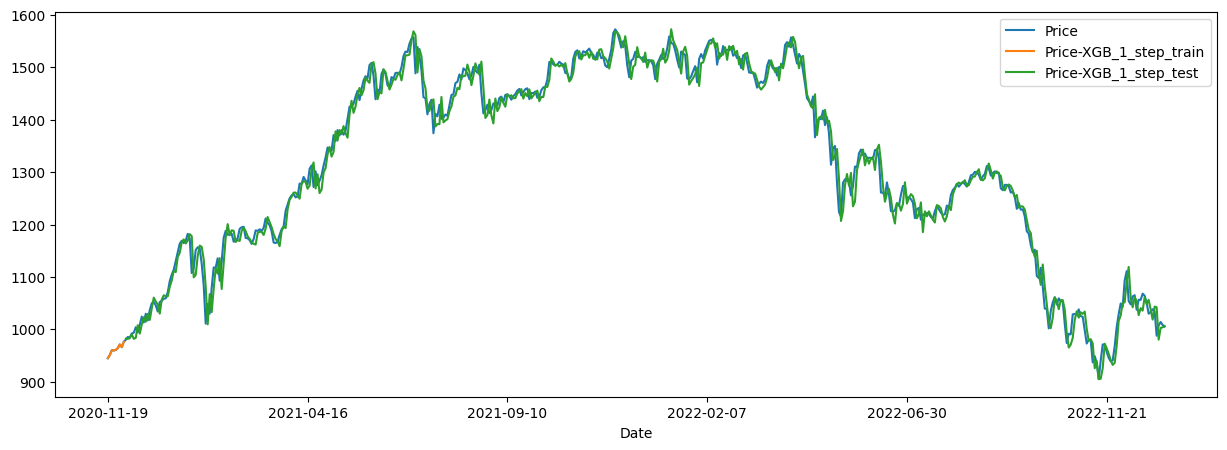

In [38]:
stock_price_df[stock_price_df.index > observe_date][['Price', 'Price-XGB_1_step_train', 'Price-XGB_1_step_test']].plot(figsize=(15,5))

In [39]:
test_X[[0], :].shape

(1, 180)

In [40]:
n_observe_days = 300
multistep_forecasting = []
last_x = test_X[[0]]
while len(multistep_forecasting) < n_observe_days:
    p = xgboost_model.predict(last_x)
    multistep_forecasting.append(p)
    last_x = np.roll(last_x, -n_features)
    for i in range(n_features):
        last_x[0, -(n_features-i)] = p[0, i]


In [41]:
import copy
multistep_idx = copy.deepcopy(test_idx)
multistep_idx[n_train_days+n_days_lag+1+n_observe_days:] = False
multistep_idx.sum()

300

In [42]:
for i, col in enumerate(column_names):
    last_train = stock_price_df.iloc[n_train_days+n_days_lag][col]
    stock_price_df.loc[multistep_idx, f'{col}-XGB_multistep'] = last_train + np.cumsum([p[0,i] for  p in multistep_forecasting])

<Axes: xlabel='Date'>

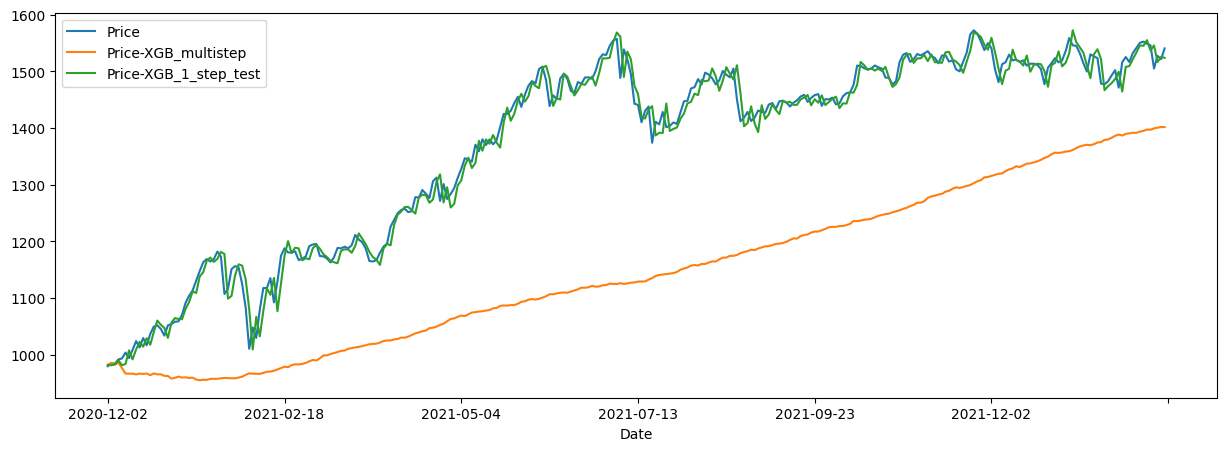

In [43]:
stock_price_df[multistep_idx][['Price', 'Price-XGB_multistep', 'Price-XGB_1_step_test']].plot(figsize=(15,5))

In [45]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})
def adjust(val, length= 6): return str(val).ljust(length)


In [47]:
print('\nForecast Accuracy of One-step ahead: VN30')
test = stock_price_df.copy()[['Price-XGB_1_step_test', 'Price']]
test.dropna(inplace=True)
accuracy_prod = forecast_accuracy(test['Price-XGB_1_step_test'].values, test['Price'].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))


Forecast Accuracy of One-step ahead: VN30
mape   :  0.0121
me     :  -1.7987
mae    :  15.4132
mpe    :  -0.0013
rmse   :  20.9307
corr   :  0.9935
minmax :  0.012
